In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1


In [4]:
!{sys.executable} -m pip install --upgrade --no-deps git+https://github.com/jgraving/unwrap

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to /tmp/pip-req-build-ihmzgmdj
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /tmp/pip-req-build-ihmzgmdj
  Resolved https://github.com/jgraving/unwrap to commit 9567136cb65fe506c37f629d43639bcbb06781c0
  Preparing metadata (setup.py) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11723 sha256=16dde25bb20a76969c77aa527c9921f7bc7139487941dff0f0ca75c3253ac2dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3xktxzf/wheels/2d/84/50/d9d5015af0946ca454640609d86c9175df59e17f1a39b13349
Successfully built unwrap

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# import numpy as np
# import pandas as pd
# import bambi as bmb
# import arviz as az
# import matplotlib.pyplot as plt

# from unwrap.link.numpy import inverse_softplus
# from unwrap.prior import CircularUniformPrior
# from unwrap.link.bambi import LINKS

# # -------------------------
# # Prepare Data and Save to Parquet (run once)
# # -------------------------
# csv_filepath = '/media/herd_hover/circular_stats_data/zebra_bearings.csv'
# parquet_filepath = 'zebra_bearings_blocks.parquet'

# df = pd.read_csv(csv_filepath, index_col=0)

# # Map original pre_scare (assumed 1=pre, 0=post) to neutral labels
# df["Condition"] = np.where(df["pre_scare"].astype(int) == 1, "pre-approach", "post-approach")
# df["Condition"] = pd.Categorical(
#     df["Condition"],
#     categories=["pre-approach", "post-approach"],
#     ordered=True,
# )

# block_size = 300

# # Group by track and condition (neutral)
# groups = df.groupby(["track_number", "Condition"])

# rows = []
# for (track, cond), group in groups:
#     blocks = [group.iloc[i:i+block_size] for i in range(0, len(group), block_size)]
#     for block in blocks:
#         if len(block) < block_size:
#             continue
#         mean_x = np.mean(np.cos(np.deg2rad(block["compass_bearing"])))
#         mean_y = np.mean(np.sin(np.deg2rad(block["compass_bearing"])))
#         angle = np.arctan2(mean_y, mean_x)
#         rows.append({
#             "Track": track,
#             "Observation": block["observation"].iloc[0],
#             "Condition": cond,
#             "HeadingRadians": angle,
#         })

# df_blocks = pd.DataFrame(rows)

# # Optional numeric convenience flag
# df_blocks["PostStimulus"] = (df_blocks["Condition"] == "post-approach").astype(int)

# # Keep only tracks that have both conditions
# track_counts = df_blocks.groupby("Track")["Condition"].nunique()
# valid_tracks = track_counts[track_counts == 2].index
# df_blocks = df_blocks[df_blocks["Track"].isin(valid_tracks)]

# # Optional: subset specific observations
# df_blocks = df_blocks[df_blocks["Track"].str.contains("observation088", na=False)]

# # ---- Save preprocessed / filtered data to Parquet ----
# df_blocks.to_parquet(parquet_filepath, index=False)
# print(f"Saved preprocessed data to {parquet_filepath}")


/tmp/ipykernel_427294/3499611346.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(["track_number", "Condition"])


Saved preprocessed data to zebra_bearings_blocks.parquet


In [1]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
from unwrap.link.bambi import LINKS

# -------------------------
# Load Preprocessed Data from Parquet
# -------------------------
parquet_filepath = 'zebra_bearings_blocks.parquet'
df_blocks = pd.read_parquet(parquet_filepath)

# If you want to be explicit about categories (optional, usually preserved in Parquet):
df_blocks["Condition"] = pd.Categorical(
    df_blocks["Condition"],
    categories=["pre-approach", "post-approach"],
    ordered=True,
)

print(df_blocks.head())


              Track     Observation     Condition  HeadingRadians  \
0  observation088-0  observation088  pre-approach        1.324933   
1  observation088-0  observation088  pre-approach        1.455568   
2  observation088-0  observation088  pre-approach        1.578286   
3  observation088-0  observation088  pre-approach        1.412140   
4  observation088-0  observation088  pre-approach        1.778967   

   PostStimulus  
0             0  
1             0  
2             0  
3             0  
4             0  


In [2]:
df_blocks

,Track,Observation,Condition,HeadingRadians,PostStimulus
0,observation088-0,observation088,pre-approach,1.324933,0
1,observation088-0,observation088,pre-approach,1.455568,0
2,observation088-0,observation088,pre-approach,1.578286,0
3,observation088-0,observation088,pre-approach,1.412140,0
4,observation088-0,observation088,pre-approach,1.778967,0
...,...,...,...,...,...
5412,observation088-9,observation088,post-approach,0.590454,1
5413,observation088-9,observation088,post-approach,0.681380,1
5414,observation088-9,observation088,post-approach,1.071873,1
5415,observation088-9,observation088,post-approach,1.190802,1


In [3]:
df_blocks["Track"].nunique()

18

In [51]:
# -------------------------
# Bambi Circular Model (neutral wording)
# -------------------------
formula = bmb.Formula(
    # Mean Angle (mu) submodel
    "HeadingRadians ~ PostStimulus + (1 + PostStimulus | Track)",
    # Concentration (kappa) submodel
    "kappa ~ PostStimulus + (1 + PostStimulus | Track)",
)

priors = {
    # Angle (mu) part
    "Intercept": bmb.Prior("VonMises", mu=0, kappa=1e-6),   # ~uniform baseline on mean direction
    "PostStimulus": bmb.Prior("VonMises", mu=0, kappa=2.0),  # mild effect prior

    # Random intercept and slope on the angle
    "1|Track": bmb.Prior(
        "VonMises",
        mu=0,
        kappa=bmb.Prior("LogNormal", mu=np.log(30.0), sigma=0.5)
    ),
    "PostStimulus|Track": bmb.Prior(
        "VonMises",
        mu=0,
        kappa=bmb.Prior("LogNormal", mu=np.log(30.0), sigma=0.5)
    ),

    # kappa (concentration) submodel
    "kappa": {
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1.0),
        "PostStimulus": bmb.Prior("Normal", mu=0, sigma=2.0),
        "1|Track": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.0)),
        "PostStimulus|Track": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.0)),
    },
}

model = bmb.Model(
    formula,
    df_blocks,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["circ_mod"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

idata = model.fit(tune=2000, target_accept=0.8)


       Formula: HeadingRadians ~ PostStimulus + (1 + PostStimulus | Track)
                kappa ~ PostStimulus + (1 + PostStimulus | Track)
        Family: vonmises
          Link: mu = circ_mod
                kappa = softplus
  Observations: 5417
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 0.0, kappa: 0.0)
            PostStimulus ~ VonMises(mu: 0.0, kappa: 2.0)
        
        Group-level effects
            1|Track ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.5))
            PostStimulus|Track ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.5))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_PostStimulus ~ Normal(mu: 0.0, sigma: 2.0)
        
        Group-level effects
            kappa_1|Track ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.0))
            kappa_PostStimulus|Track ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PostStimulus, 1|Track_kappa, 1|Track, PostStimulus|Track_kappa, PostStimulus|Track, kappa_Intercept, kappa_PostStimulus, kappa_1|Track_sigma, kappa_1|Track_offset, kappa_PostStimulus|Track_sigma, kappa_PostStimulus|Track_offset]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 269 seconds.


In [52]:
import arviz as az

In [53]:
summary_df = az.summary(idata, circ_var_names=["Intercept", "PostStimulus", "1|Track"])

In [54]:
summary_df[(summary_df["ess_bulk"]<400) | summary_df["r_hat"]>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns 

# ============================================================
# Helper functions
# ============================================================
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)

def circ_mod(x):
    # wrap to (-pi, pi]
    return (x + np.pi) % (2*np.pi) - np.pi

def wrap_0_2pi(x):
    return x % (2*np.pi)

def circ_mean(a, axis=None):
    a = np.asarray(a)
    s = np.sin(a).mean(axis=axis)
    c = np.cos(a).mean(axis=axis)
    return (np.arctan2(s, c)) % (2*np.pi)

def circ_hdi(samples, prob=0.95):
    """Smallest arc on [0, 2π) containing `prob` mass."""
    a = np.sort(samples % (2*np.pi))
    n = len(a)
    k = int(np.ceil(prob * n))
    a_ext = np.concatenate([a, a + 2*np.pi])
    spans = a_ext[k-1:n + k-1] - a
    j = np.argmin(spans)
    low = a[j]
    high = (a_ext[j + k - 1]) % (2*np.pi)
    return low, high

def as_samples(da):
    """Flatten xarray (chain, draw, *levels) into (S, *levels)."""
    vals = da.values
    if vals.ndim == 2:  # (chain, draw)
        c, d = vals.shape
        return vals.reshape(c * d)
    elif vals.ndim == 1:
        return vals
    elif vals.ndim == 3:  # (chain, draw, level)
        c, d, L = vals.shape
        return vals.reshape(c * d, L)
    else:
        raise ValueError(f"Unexpected shape {vals.shape}")

def circ_mean_series(a):
    a = np.asarray(a)
    if a.size == 0:
        return np.nan
    return circ_mean(wrap_0_2pi(a))

def arc_width(a, b):
    return (b - a) % (2 * np.pi)

# ============================================================
# Posterior extraction & design grid
# ============================================================
post = idata.posterior  # assumes `idata` already exists

# fixed effects (mu)
mu_intercept_name = "Intercept"
mu_post_name = "PostStimulus" if "PostStimulus" in post.data_vars else None

# group effect for mu (random intercept per Track)
mu_g_name = None
for v in post.data_vars:
    if ("|Track" in v) and (not v.startswith("kappa_")) and ("PostStimulus|Track" not in v):
        mu_g_name = v
        break

# random slope for PostStimulus by Track for mu
mu_g_post_name = None
for v in post.data_vars:
    if ("PostStimulus|Track" in v) and (not v.startswith("kappa_")):
        mu_g_post_name = v
        break

# fixed effects (kappa)
k_intercept_name = "kappa_Intercept" if "kappa_Intercept" in post.data_vars else None
k_post_name = "kappa_PostStimulus" if "kappa_PostStimulus" in post.data_vars else None

# group effect for kappa (random intercept)
k_g_name = None
for v in post.data_vars:
    if v.startswith("kappa_") and ("|Track" in v) and ("PostStimulus|Track" not in v):
        k_g_name = v
        break

# random slope for PostStimulus by Track for kappa
k_g_post_name = None
for v in post.data_vars:
    if v.startswith("kappa_") and ("PostStimulus|Track" in v):
        k_g_post_name = v
        break

# sanity checks
if mu_intercept_name not in post:
    raise RuntimeError("Could not find mu Intercept in posterior.")
if (k_intercept_name is None) or (k_intercept_name not in post):
    raise RuntimeError("Could not find kappa_Intercept in posterior.")

# Tracks and grid: each Track × {pre (0), post (1)}
tracks = np.sort(df_blocks["Track"].unique())
nT = len(tracks)

grid = pd.DataFrame({
    "PostStimulus": np.repeat([0, 1], nT),
    "Track":        np.tile(tracks, 2),
})

idx_pre  = np.arange(0, nT)
idx_post = np.arange(nT, 2 * nT)

# ============================================================
# Build linear predictors η_mu, η_kappa per posterior sample
# ============================================================
S = post.sizes["chain"] * post.sizes["draw"]
eta_mu   = np.zeros((S, 2 * nT))
eta_kapp = np.zeros((S, 2 * nT))

# intercepts
eta_mu   += as_samples(post[mu_intercept_name])[:, None]
eta_kapp += as_samples(post[k_intercept_name])[:, None]

# fixed effect PostStimulus
if mu_post_name is not None:
    b = as_samples(post[mu_post_name])  # (S,)
    eta_mu[:, idx_post] += b[:, None]
if k_post_name is not None:
    bk = as_samples(post[k_post_name])
    eta_kapp[:, idx_post] += bk[:, None]

# random intercepts per Track for mu
if mu_g_name is not None:
    mu_g = as_samples(post[mu_g_name])  # (S, L)
    coord_name = [cn for cn in post[mu_g_name].coords if cn not in ("chain", "draw")][0]
    levels = np.array(post[mu_g_name][coord_name].values).astype(str)
    level_idx = {lev: i for i, lev in enumerate(levels)}
    miss = [t for t in tracks if t not in level_idx]
    if miss:
        raise RuntimeError(f"Tracks missing in posterior RE for mu: {miss}")
    for j, t in enumerate(tracks):
        eta_mu[:, j]       += mu_g[:, level_idx[t]]   # pre row
        eta_mu[:, nT + j]  += mu_g[:, level_idx[t]]   # post row

# random slope PostStimulus|Track for mu (post rows only)
if mu_g_post_name is not None:
    mu_g_post = as_samples(post[mu_g_post_name])  # (S, L)
    coord_name_mu_post = [cn for cn in post[mu_g_post_name].coords
                          if cn not in ("chain", "draw")][0]
    levels_mu_post = np.array(post[mu_g_post_name][coord_name_mu_post].values).astype(str)
    level_idx_mu_post = {lev: i for i, lev in enumerate(levels_mu_post)}
    miss_mu_post = [t for t in tracks if t not in level_idx_mu_post]
    if miss_mu_post:
        raise RuntimeError(f"Tracks missing in mu PostStimulus|Track RE: {miss_mu_post}")
    for j, t in enumerate(tracks):
        eta_mu[:, nT + j] += mu_g_post[:, level_idx_mu_post[t]]

# random intercepts per Track for kappa
if k_g_name is not None:
    kg = as_samples(post[k_g_name])  # (S, L)
    coord_name_k = [cn for cn in post[k_g_name].coords if cn not in ("chain", "draw")][0]
    levels_k = np.array(post[k_g_name][coord_name_k].values).astype(str)
    level_idx_k = {lev: i for i, lev in enumerate(levels_k)}
    missk = [t for t in tracks if t not in level_idx_k]
    if missk:
        raise RuntimeError(f"Tracks missing in posterior RE for kappa: {missk}")
    for j, t in enumerate(tracks):
        eta_kapp[:, j]      += kg[:, level_idx_k[t]]
        eta_kapp[:, nT + j] += kg[:, level_idx_k[t]]

# random slope kappa_PostStimulus|Track (post rows only)
if k_g_post_name is not None:
    kg_post = as_samples(post[k_g_post_name])  # (S, L)
    coord_name_kg_post = [cn for cn in post[k_g_post_name].coords
                          if cn not in ("chain", "draw")][0]
    levels_kg_post = np.array(post[k_g_post_name][coord_name_kg_post].values).astype(str)
    level_idx_kg_post = {lev: i for i, lev in enumerate(levels_kg_post)}
    misskg_post = [t for t in tracks if t not in level_idx_kg_post]
    if misskg_post:
        raise RuntimeError(f"Tracks missing in kappa PostStimulus|Track RE: {misskg_post}")
    for j, t in enumerate(tracks):
        eta_kapp[:, nT + j] += kg_post[:, level_idx_kg_post[t]]

# ============================================================
# Apply links
# ============================================================
mu    = circ_mod(eta_mu)     # (-π, π]
kappa = softplus(eta_kapp)   # > 0



/tmp/ipykernel_427390/1273601139.py:225: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


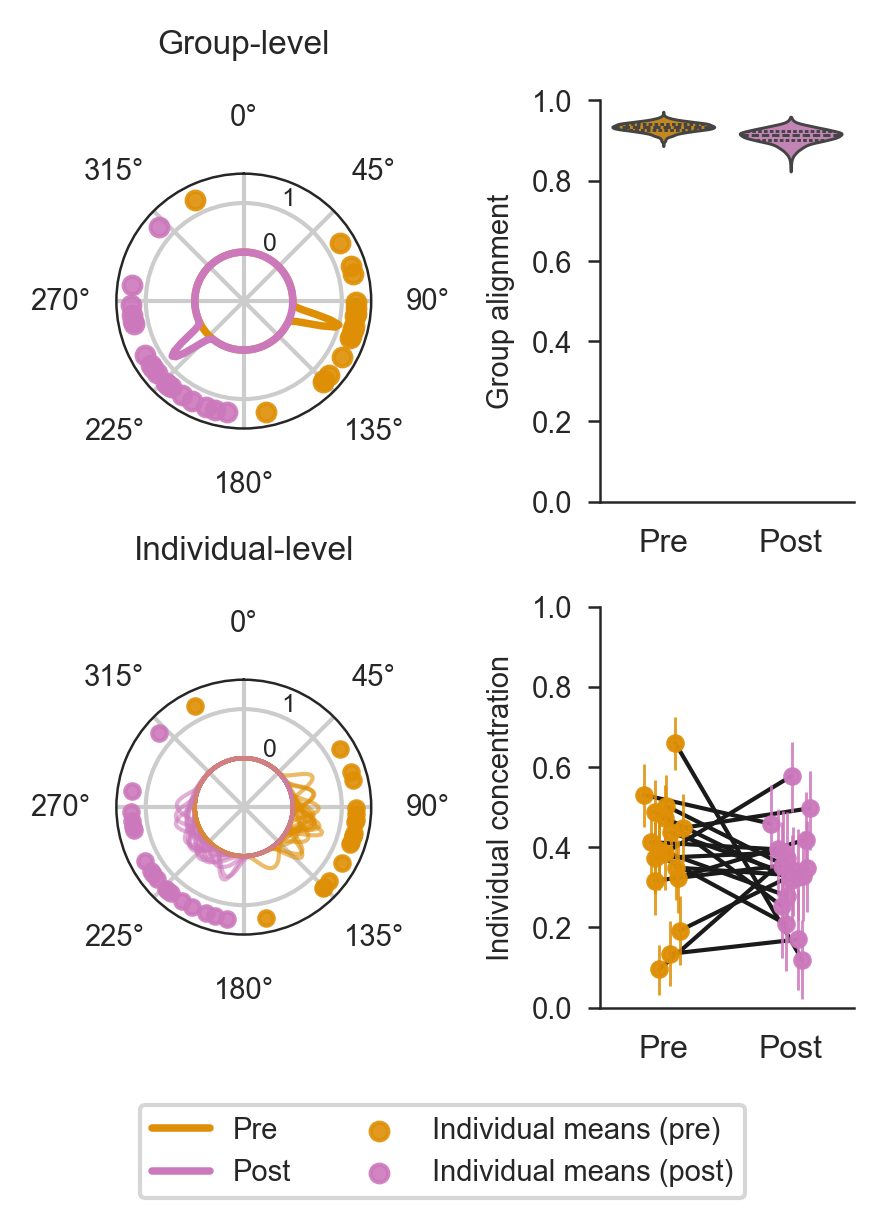

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from scipy.special import i0, i1   # NEW: for R = I1(kappa)/I0(kappa)
import matplotlib.lines as mlines

# -------------------------------------------------------------------
# Style + colours
# -------------------------------------------------------------------
sns.set_theme(style="white", context="notebook", font_scale=0.7)

_cb = sns.color_palette("colorblind")
PRE_COLOR  = _cb[1]  # orange = pre-stimulus
POST_COLOR = _cb[4]  # purple = post-stimulus

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.linewidth": 0.6,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
})

tracks = np.sort(df_blocks["Track"].unique())
nT     = len(tracks)
idx_pre  = np.arange(0, nT)
idx_post = np.arange(nT, 2 * nT)
S = mu.shape[0]

# -------------------------------------------------------------------
# Small helpers
# -------------------------------------------------------------------
def linear_hdi(samples, prob=0.95):
    s = np.sort(np.asarray(samples))
    n = s.size
    if n == 0:
        return np.nan, np.nan
    k = int(np.ceil(prob * n))
    spans = s[k-1:] - s[:n-k+1]
    j = np.argmin(spans)
    return s[j], s[j + k - 1]

def resultant_length(a, axis=-1):
    a = np.asarray(a)
    return np.sqrt(np.mean(np.cos(a), axis=axis)**2 +
                   np.mean(np.sin(a), axis=axis)**2)

# -------------------------------------------------------------------
# Population-level μ (per draw across individuals)
# -------------------------------------------------------------------
pre_mu_draw  = circ_mean(wrap_0_2pi(mu[:, idx_pre]),  axis=1)   # (S,)
post_mu_draw = circ_mean(wrap_0_2pi(mu[:, idx_post]), axis=1)   # (S,)

mu_pop_pre_all  = circ_mod(pre_mu_draw)
mu_pop_post_all = circ_mod(post_mu_draw)

# -------------------------------------------------------------------
# Individual-level μ (per draw, per individual)
# -------------------------------------------------------------------
per_ind_pre_samples  = circ_mod(mu[:, idx_pre])     # (S, nT)
per_ind_post_samples = circ_mod(mu[:, idx_post])    # (S, nT)

# -------------------------------------------------------------------
# Individual-level κ samples (per draw per individual)
# -------------------------------------------------------------------
kappa_pre_samples  = kappa[:, idx_pre]   # (S, nT)
kappa_post_samples = kappa[:, idx_post]  # (S, nT)

# -------------------------------------------------------------------
# Within-zebra alignment R_ind from κ:
# R_ind = I1(κ) / I0(κ)  (bottom-right panel)
# -------------------------------------------------------------------
R_ind_pre_samples  = i1(kappa_pre_samples)  / i0(kappa_pre_samples)   # (S, nT)
R_ind_post_samples = i1(kappa_post_samples) / i0(kappa_post_samples)  # (S, nT)

R_ind_pre_mean  = R_ind_pre_samples.mean(axis=0)   # (nT,)
R_ind_post_mean = R_ind_post_samples.mean(axis=0)  # (nT,)

R_ind_pre_hdi  = np.array([linear_hdi(R_ind_pre_samples[:, j],  prob=0.95)
                           for j in range(nT)])    # (nT, 2)
R_ind_post_hdi = np.array([linear_hdi(R_ind_post_samples[:, j], prob=0.95)
                           for j in range(nT)])    # (nT, 2)

# -------------------------------------------------------------------
# Empirical individual circular means from raw data (for dots)
# -------------------------------------------------------------------
per_ind_pre_data  = []
per_ind_post_data = []

for t in tracks:
    d_t = df_blocks[df_blocks["Track"] == t]
    h_pre  = d_t.loc[d_t["PostStimulus"] == 0, "HeadingRadians"].dropna().values
    h_post = d_t.loc[d_t["PostStimulus"] == 1, "HeadingRadians"].dropna().values

    m_pre  = np.nan if h_pre.size  == 0 else circmean(h_pre,  high=np.pi, low=-np.pi)
    m_post = np.nan if h_post.size == 0 else circmean(h_post, high=np.pi, low=-np.pi)

    per_ind_pre_data.append(m_pre)
    per_ind_post_data.append(m_post)

per_ind_pre_data  = np.array(per_ind_pre_data)
per_ind_post_data = np.array(per_ind_post_data)

# -------------------------------------------------------------------
# Circular KDEs (von Mises kernels) – for μ panels
# -------------------------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

kappa_bw_pop = 500  # population μ
kappa_bw_ind = 300  # individual μ

# population μ KDEs (1 per treatment)
kde_mu_pop_pre = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bw_pop,
                 loc=mu_pop_pre_all[:, None]),
    axis=0
)
kde_mu_pop_post = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bw_pop,
                 loc=mu_pop_post_all[:, None]),
    axis=0
)

# individual μ KDEs: 1 per individual per treatment  -> arrays (nT, len(theta))
kde_mu_ind_pre  = np.zeros((nT, theta.size))
kde_mu_ind_post = np.zeros((nT, theta.size))

for j in range(nT):
    # pre
    s_pre = per_ind_pre_samples[:, j]
    kde_mu_ind_pre[j] = np.mean(
        vonmises.pdf(theta[None, :],
                     kappa=kappa_bw_ind,
                     loc=s_pre[:, None]),
        axis=0
    )
    # post
    s_post = per_ind_post_samples[:, j]
    kde_mu_ind_post[j] = np.mean(
        vonmises.pdf(theta[None, :],
                     kappa=kappa_bw_ind,
                     loc=s_post[:, None]),
        axis=0
    )

# -------------------------------------------------------------------
# Group alignment R of individual mean headings (top-right panel)
# -------------------------------------------------------------------
R_pre_draw  = resultant_length(per_ind_pre_samples,  axis=1)  # (S,)
R_post_draw = resultant_length(per_ind_post_samples, axis=1)  # (S,)

df_R = pd.DataFrame({
    "Condition": (["Pre"] * len(R_pre_draw) +
                  ["Post"] * len(R_post_draw)),
    "Alignment": np.concatenate([R_pre_draw, R_post_draw]),
})

# -------------------------------------------------------------------
# Global scaling for μ KDE radius (same for polar panels)
# -------------------------------------------------------------------
max_kde_all = max(
    kde_mu_pop_pre.max(),
    kde_mu_pop_post.max(),
    kde_mu_ind_pre.max(),
    kde_mu_ind_post.max(),
)

def scale_kde(kde):
    return 1.0 + kde / max_kde_all  # KDE 0 -> r=1, max -> r=2

r_pop_pre  = scale_kde(kde_mu_pop_pre)
r_pop_post = scale_kde(kde_mu_pop_post)

r_ind_pre  = scale_kde(kde_mu_ind_pre)   # shape (nT, len(theta))
r_ind_post = scale_kde(kde_mu_ind_post)

r_dot = 2.3
rmax  = 2.6
rticks      = [1.0, 2.0]
rticklabels = ["0", "1"]   # relative density

# -------------------------------------------------------------------
# Figure: 2×2 panels (Population top, Individual bottom)
# -------------------------------------------------------------------
fig = plt.figure(figsize=(3.0, 4.0), dpi=300)
gs  = fig.add_gridspec(2, 2, width_ratios=[0.5, 0.5])

ax_mu_pop    = fig.add_subplot(gs[0, 0], projection="polar")
ax_R_pop     = fig.add_subplot(gs[0, 1])
ax_mu_ind    = fig.add_subplot(gs[1, 0], projection="polar")
ax_R_ind     = fig.add_subplot(gs[1, 1])

# common polar settings
for ax in (ax_mu_pop, ax_mu_ind):
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlim(0, rmax)
    ax.set_rticks(rticks)
    ax.set_yticklabels(rticklabels)
    ax.tick_params(axis="x", which="major", labelsize=7)
    ax.tick_params(axis="y", which="major", labelsize=6)

# ---------- (A) Population μ ----------
ax_mu_pop.plot(theta, r_pop_pre,  color=PRE_COLOR,  lw=1.8, label="Pre")
ax_mu_pop.plot(theta, r_pop_post, color=POST_COLOR, lw=1.8, label="Post")

# empirical individual means (dots) — only once in this panel
for i, (m_pre, m_post) in enumerate(zip(per_ind_pre_data, per_ind_post_data)):
    if not np.isnan(m_pre):
        ax_mu_pop.scatter(m_pre,  r_dot, color=PRE_COLOR,  alpha=0.9, s=18,
                          label="Individual means (pre)"  if i == 0 else "")
    if not np.isnan(m_post):
        ax_mu_pop.scatter(m_post, r_dot, color=POST_COLOR, alpha=0.9, s=18,
                          label="Individual means (post)" if i == 0 else "")

ax_mu_pop.set_title(r"Group-level", pad=12, fontsize=8)

# ---------- (B) Group directional alignment (R) ----------
sns.violinplot(
    x="Condition", y="Alignment",
    data=df_R,
    order=["Pre", "Post"],
    palette={"Pre": PRE_COLOR, "Post": POST_COLOR},
    inner="quartile", cut=0, linewidth=0.7, ax=ax_R_pop
)
ax_R_pop.set_xlabel("")
ax_R_pop.set_ylabel("Group alignment", fontsize=7)
ax_R_pop.set_ylim(0, 1.0)
ax_R_pop.tick_params(axis="y", which="both",
                     labelleft=True,
                     length=3, width=0.6, labelsize=7)
if ax_R_pop.get_legend() is not None:
    ax_R_pop.get_legend().remove()
for spine in ["top", "right"]:
    ax_R_pop.spines[spine].set_visible(False)

# ---------- (C) Individual μ ----------
for j in range(nT):
    ax_mu_ind.plot(theta, r_ind_pre[j],
                   color=PRE_COLOR, alpha=0.6, lw=1.0)
    ax_mu_ind.plot(theta, r_ind_post[j],
                   color=POST_COLOR, alpha=0.6, lw=1.0)

for (m_pre, m_post) in zip(per_ind_pre_data, per_ind_post_data):
    if not np.isnan(m_pre):
        ax_mu_ind.scatter(m_pre,  r_dot, color=PRE_COLOR,  alpha=0.9, s=12)
    if not np.isnan(m_post):
        ax_mu_ind.scatter(m_post, r_dot, color=POST_COLOR, alpha=0.9, s=12)

ax_mu_ind.set_title(r"Individual-level", pad=12, fontsize=8)

# ---------- (D) Within-zebra alignment (R_ind): jittered points + 95% HDIs + paired lines ----------
rng = np.random.default_rng(123)

# one jitter per individual, reused for pre and post
delta = rng.normal(loc=0.0, scale=0.1, size=nT)
x_pre  = 0.0 + delta
x_post = 1.0 + delta

# draw connecting lines first (so they sit under the points)
for j in range(nT):
    ax_R_ind.plot(
        [x_pre[j], x_post[j]],
        [R_ind_pre_mean[j], R_ind_post_mean[j]],
        color="k", linewidth=1.0, alpha=1.0, zorder=0,
    )

# Pre
for j in range(nT):
    lo, hi = R_ind_pre_hdi[j]
    m = R_ind_pre_mean[j]
    ax_R_ind.vlines(x_pre[j], lo, hi,
                    color=PRE_COLOR, alpha=0.85, linewidth=0.7, zorder=1)
    ax_R_ind.scatter(x_pre[j], m,
                     color=PRE_COLOR, s=12, alpha=0.95, zorder=2)

# Post
for j in range(nT):
    lo, hi = R_ind_post_hdi[j]
    m = R_ind_post_mean[j]
    ax_R_ind.vlines(x_post[j], lo, hi,
                    color=POST_COLOR, alpha=0.85, linewidth=0.7, zorder=1)
    ax_R_ind.scatter(x_post[j], m,
                     color=POST_COLOR, s=12, alpha=0.95, zorder=2)

ax_R_ind.set_xticks([0, 1])
ax_R_ind.set_xticklabels(["Pre", "Post"])
ax_R_ind.set_xlabel("")
ax_R_ind.set_ylabel("Individual concentration", fontsize=7)
ax_R_ind.tick_params(axis="y", which="both",
                     labelleft=True,
                     length=3, width=0.6, labelsize=7)

ax_R_ind.set_ylim(0, 1.0)
ax_R_ind.set_xlim(-0.5, 1.5)

for spine in ["top", "right"]:
    ax_R_ind.spines[spine].set_visible(False)

# make sure tick *lines* are visible on right-column axes
for ax in (ax_R_pop, ax_R_ind):
    ax.yaxis.set_ticks_position("left")
    ax.tick_params(axis="y", which="major", length=3, width=0.6)

plt.tight_layout()

# ---------- Common legend ----------
handles, labels = ax_mu_pop.get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="",
    loc="lower center",
    ncol=2,
    fontsize=7,
    frameon=True,
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()
